# A WalkThrough Guide to `Plate` and the models
In this notebook I show some examples of how to use the "new and improved" interface for analysing your plates.
Instead of individual functions in a file, I have made a class called `Plate`, which represents one plate experiment.
This class comes with its own methods for getting the data into the desirable long format, visualizing the curves, doing curve fitting and
computing area under the curve. It also comes with functionality making it easy to add metadata to the DataFrames, and for adding two different `Plates` together.

In `models.py` a couple of curve fitting models can be found:
* `LogisticZero`: A simple logistic function (3 parameters)
* `Logistic2kZero`: A logistic function with two rate parameters (4 parameters)
* `Logistic2k`: A logistic function with two rate parameters (5 parameters)
* `RichardsZero`: A Richards-type function (4 parameters)
* `Richards`: A Richards-type function (5 parameters)
* `GompertzZero`: A Gompertz-type function (3 parameters)
* `Gompertz`: A Gompertz-type function (4 parameters)

The `Zero` models have fixed, lower asymptotes located at `y=0`, while the non-`Zero` models optimizes the lower asymptotes.
The `2k` models optimize two independent rate parameters, which allows for more flexibility and more asymmetrical curves.

From my testing, I have found that the `2k` models give more qualitatively correct fits. By this I mean that the inflection point actually is located
in the high-growth region of the data. The estimation of max growth rates is very sensitive to qualitatively correct fits, and for tricky and asymmetrical data
I find that the `2k` models work better. The downside is that one loses the intuitive interpretation of the model parameters, since the inflection point and max rate must be
computed numerically. This is done by finding the root to the equation

$$
\frac{d^2}{dx^2} f(x) = 0
$$

and then plug this into the function's first derivative. Calculating the root is done with `scipy.optimize.fsolve`, and sometimes this does not converge, preventing the max rate from being estimated.

### ToDo
* What to do about units? How should the rates and areas be reported?
* Are there better models out there for asymmetrical data with intuitive parameters?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

from plate import Plate
from models import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# Creating a `Plate` object
The `Plate` class takes two mandatory arguments (in the following order):
* Path to a CSV file containing the plate layout
* Path to a CSV file containing the raw data

Additional arguments are
* `blank_name`: Name used in template to indicate blank wells
* `ID`: An identifier that is used in output filename generation, and in comparisons of multiple `Plate` objects
* `delimiter`: Delimiter used in the template and raw data CSV files

In addition, you can pass an `ID` which will be stored with the object, and added as metadata to the dataframes.

Several things take place when you create a `Plate`:
1. The template is converted to a DataFrame
2. The raw data is converted to a DataFrame
3. A long-form version of the data is made as a second DataFrame
4. The replicates are combined into a third DataFrame

The raw data DataFrame is not used for anything, except as a starting point. All analyses are done on the long-form and combined DataFrames, and curve fitting is done on log-transformed relative y-data $y`$:

$$
y`= \log_2 (\frac{y}{\min y})
$$

This ensures that the data is positive, and that the growth curves start at zero (unless the curves are weird).

In [2]:
template = 'Templates/Template_pseudomonas.csv'
raw = 'SampleData/Artificial1.csv'
plate = Plate(template=template, data=raw, blank_name='Blank', ID='SampleData1')

/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Getting help on the `Plate` object
You can get information about available methods in the Plate class, and see their docstrings, with the `help` function...

In [3]:
help(Plate)

Help on class Plate in module plate:

class Plate(builtins.object)
 |  Plate(template=None, data=None, blank_name='Blank', ID=None, delimiter=',')
 |  
 |  Class representing a plate experiment.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, other)
 |      Overload the + operator so that two Plates can easily be concatenated.
 |  
 |  __init__(self, template=None, data=None, blank_name='Blank', ID=None, delimiter=',')
 |      Parameters
 |      -----------
 |      template <str>: path to template CSV file
 |      data <str>: path to wideform CSV file
 |      blank_name <str>: Name of blank wells
 |      ID <str>: Unique identifier for this plate object
 |      delimiter <str>: which delimiter used in CSV files (Default: ,)
 |  
 |  add_metadata(self, key, val)
 |      Add column to long and combined DataFrames.
 |      
 |      Paramters
 |      ----------
 |      key <str>: Name of column to add
 |      val <str>: Column value to add
 |  
 |  analyze(self, modelname='logistic2k

...or on individual methods

In [4]:
help(plate.show_all_curves)

Help on method show_all_curves in module plate:

show_all_curves(col_wrap=10, savefig=False, filename=None, sharey=True, temp=True, outputdir='.') method of plate.Plate instance
    Plot all growth curves in a Seaborn relplot.
    
    Parameters
    -----------
    col_wrap <int>: Number of columns in each row
    savefig <bool>: Write figure to a PNG file
    filename <str>: Filename of figure PNG file



# Retrieving the data

You can access the three DataFrames in the following way:
* `plate.wide`
* `plate.long`
* `plate.combined`

In [5]:
plate.raw.head()

,Time,Time_hours,Temp,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
0,00:00:00,0.00,25.0,0.089088,0.002392,0.039860,0.008231,0.052974,0.064652,0.008767,0.009117,0.074929,0.019827,0.028621,0.080189,0.111411,0.103246,0.067677,0.017785,0.005729,0.095295,0.023014,0.011781,0.018424,0.027064,0.059325,0.002291,0.107041,0.110697,0.068444,0.050508,0.106884,0.069141,0.065262,0.088928,0.076220,0.067596,0.100549,0.018485,0.078920,0.108822,0.002614,0.095400,0.047934,0.055842,0.103298,0.105378,0.106321,0.071262,0.029555,0.076538,0.092469,0.051699,0.099473,0.103261,0.112607,0.052210,0.115785,0.048120,0.061985,0.114929,0.075102,0.082467
1,00:14:32,0.25,25.0,0.092928,0.002454,0.041246,0.008429,0.055382,0.067391,0.009083,0.009362,0.076936,0.020288,0.029394,0.082263,0.113152,0.105987,0.070010,0.018393,0.005880,0.098639,0.024247,0.011981,0.019088,0.027776,0.061336,0.002332,0.110969,0.114548,0.071394,0.052281,0.106884,0.070869,0.067513,0.091170,0.078158,0.069795,0.104810,0.019282,0.080269,0.113595,0.002679,0.096188,0.049195,0.056822,0.106041,0.107120,0.110052,0.073637,0.030065,0.077917,0.094050,0.052970,0.103724,0.106703,0.115545,0.053965,0.118564,0.048902,0.063602,0.116894,0.077061,0.083155
2,00:29:35,0.50,25.1,0.094464,0.002495,0.041940,0.008495,0.056345,0.068487,0.009083,0.009362,0.077605,0.020595,0.029910,0.083645,0.114022,0.108728,0.071177,0.018849,0.006030,0.100311,0.024864,0.012080,0.019420,0.028251,0.062341,0.002393,0.111951,0.115510,0.073164,0.053610,0.108622,0.072022,0.069763,0.092664,0.079450,0.070344,0.106514,0.019601,0.082967,0.115504,0.002700,0.096976,0.051298,0.059761,0.111526,0.108862,0.113782,0.076013,0.030319,0.078607,0.094840,0.053818,0.105424,0.108424,0.117503,0.054404,0.120417,0.050076,0.063602,0.117876,0.077061,0.084529
3,00:44:38,0.75,25.3,0.096768,0.002537,0.042633,0.008561,0.057308,0.069583,0.009162,0.009524,0.078274,0.020903,0.030426,0.085028,0.114893,0.111469,0.072344,0.019153,0.006081,0.101147,0.025274,0.012280,0.019586,0.028726,0.063347,0.002434,0.113915,0.118398,0.073754,0.054496,0.109491,0.073174,0.069201,0.094159,0.080096,0.071443,0.108218,0.019920,0.089712,0.120277,0.002700,0.098553,0.052139,0.060251,0.111526,0.110604,0.115648,0.077201,0.030829,0.079297,0.095630,0.054666,0.107124,0.111866,0.119462,0.055720,0.122269,0.050467,0.064141,0.117876,0.077714,0.085904
4,00:59:41,1.00,25.5,0.098304,0.002598,0.043326,0.008692,0.058272,0.070679,0.009320,0.009606,0.078943,0.021364,0.031199,0.086411,0.116634,0.114211,0.073511,0.019305,0.006332,0.104491,0.025891,0.012480,0.020084,0.029201,0.064855,0.002536,0.116861,0.119361,0.075524,0.054939,0.112967,0.074902,0.071451,0.095653,0.081388,0.074741,0.109922,0.020398,0.115344,0.144141,0.002721,0.100130,0.052559,0.060741,0.114268,0.113216,0.118446,0.078388,0.031339,0.080676,0.094840,0.056361,0.109675,0.114447,0.122399,0.057036,0.124122,0.051249,0.064680,0.119841,0.077714,0.087278


In [6]:
plate.long.head()

,Time_hours,Temp,Well,Absorption,Ratio,Group,ID
0,0.00,25.0,B2,0.089088,1.000000,Glucose,SampleData1
1,0.25,25.0,B2,0.092928,1.043103,Glucose,SampleData1
2,0.50,25.1,B2,0.094464,1.060345,Glucose,SampleData1
3,0.75,25.3,B2,0.096768,1.086207,Glucose,SampleData1
4,1.00,25.5,B2,0.098304,1.103448,Glucose,SampleData1


In [7]:
plate.combined.head()

,Group,Time_hours,MeanTemp,MeanAbs,MeanRatio,StDevTemp,StDevAbs,StDevRatio,logAbs,logRatio,logStDevAbsUpper,logStDevAbsLower,logStDevRatioUpper,logStDevRatioLower,ID
0,Arabinose,0.00,25.0,0.062903,1.000000,0.0,0.042930,0.000000,-3.990738,0.000000,-3.240140,-5.645865,0.000000,0.000000,SampleData1
1,Arabinose,0.25,25.0,0.064797,1.031740,0.0,0.044029,0.004498,-3.947934,0.045079,-3.199902,-5.589539,0.051355,0.038776,SampleData1
2,Arabinose,0.50,25.1,0.066251,1.054884,0.0,0.045142,0.004338,-3.915905,0.077084,-3.166266,-5.565959,0.083004,0.071139,SampleData1
3,Arabinose,0.75,25.3,0.067655,1.075178,0.0,0.046337,0.005550,-3.885651,0.104576,-3.132996,-5.551731,0.112004,0.097110,SampleData1
4,Arabinose,1.00,25.5,0.069009,1.092624,0.0,0.047613,0.011758,-3.857078,0.127797,-3.100095,-5.546522,0.143240,0.112187,SampleData1


Additionally, you can extract x and y data easily from a sub-group of the combined DataFrame like shown below.
You can get either the log-transformed mean values, or the un-transformed mean values.

In [8]:
x, y = plate.get_xy('Glucose')

In [9]:
x.head()

1544    0.00
1545    0.25
1546    0.50
1547    0.75
1548    1.00
Name: Time_hours, dtype: float64

In [10]:
y.head()

1544    0.000000
1545    0.049049
1546    0.072962
1547    0.100357
1548    0.127242
Name: logRatio, dtype: float64

# Adding metadata
If you want to add metadata to the long and combined DataFrames, you can use the `add_metadata` method.
The first argument is the column name, and the second argument is the value.
The value is always added to all rows.

There is also a method for removing metadata: `remove_metadata(Parametername)`. The column matching
`Parametername` will be dropped inplace.

In [11]:
plate.add_metadata('Parameter1', 'Value1')

In [12]:
plate.long.head()

,Time_hours,Temp,Well,Absorption,Ratio,Group,ID,Parameter1
0,0.00,25.0,B2,0.089088,1.000000,Glucose,SampleData1,Value1
1,0.25,25.0,B2,0.092928,1.043103,Glucose,SampleData1,Value1
2,0.50,25.1,B2,0.094464,1.060345,Glucose,SampleData1,Value1
3,0.75,25.3,B2,0.096768,1.086207,Glucose,SampleData1,Value1
4,1.00,25.5,B2,0.098304,1.103448,Glucose,SampleData1,Value1


In [13]:
plate.combined.head()

,Group,Time_hours,MeanTemp,MeanAbs,MeanRatio,StDevTemp,StDevAbs,StDevRatio,logAbs,logRatio,logStDevAbsUpper,logStDevAbsLower,logStDevRatioUpper,logStDevRatioLower,ID,Parameter1
0,Arabinose,0.00,25.0,0.062903,1.000000,0.0,0.042930,0.000000,-3.990738,0.000000,-3.240140,-5.645865,0.000000,0.000000,SampleData1,Value1
1,Arabinose,0.25,25.0,0.064797,1.031740,0.0,0.044029,0.004498,-3.947934,0.045079,-3.199902,-5.589539,0.051355,0.038776,SampleData1,Value1
2,Arabinose,0.50,25.1,0.066251,1.054884,0.0,0.045142,0.004338,-3.915905,0.077084,-3.166266,-5.565959,0.083004,0.071139,SampleData1,Value1
3,Arabinose,0.75,25.3,0.067655,1.075178,0.0,0.046337,0.005550,-3.885651,0.104576,-3.132996,-5.551731,0.112004,0.097110,SampleData1,Value1
4,Arabinose,1.00,25.5,0.069009,1.092624,0.0,0.047613,0.011758,-3.857078,0.127797,-3.100095,-5.546522,0.143240,0.112187,SampleData1,Value1


In [14]:
plate.remove_metadata('Parameter1')
plate.combined.head()

,Group,Time_hours,MeanTemp,MeanAbs,MeanRatio,StDevTemp,StDevAbs,StDevRatio,logAbs,logRatio,logStDevAbsUpper,logStDevAbsLower,logStDevRatioUpper,logStDevRatioLower,ID
0,Arabinose,0.00,25.0,0.062903,1.000000,0.0,0.042930,0.000000,-3.990738,0.000000,-3.240140,-5.645865,0.000000,0.000000,SampleData1
1,Arabinose,0.25,25.0,0.064797,1.031740,0.0,0.044029,0.004498,-3.947934,0.045079,-3.199902,-5.589539,0.051355,0.038776,SampleData1
2,Arabinose,0.50,25.1,0.066251,1.054884,0.0,0.045142,0.004338,-3.915905,0.077084,-3.166266,-5.565959,0.083004,0.071139,SampleData1
3,Arabinose,0.75,25.3,0.067655,1.075178,0.0,0.046337,0.005550,-3.885651,0.104576,-3.132996,-5.551731,0.112004,0.097110,SampleData1
4,Arabinose,1.00,25.5,0.069009,1.092624,0.0,0.047613,0.011758,-3.857078,0.127797,-3.100095,-5.546522,0.143240,0.112187,SampleData1


# Making graphs
Several graphing methods are implemented:
* `show()`: Visualize the plate layout
* `show_all_curves()`: Plot growth curves for all wells
* `show_combined_curves()`: Plot the means after combining replicates
* `show_fitted_curve()`: Make a fit on specified group and display original data overlayed with fit
* `show_fitted_curves()`: Same as above, but perform fit for all curves and display in a grid.
* `show_temperatures()`: Make a scatterplot of the temperatures throughout the experiment.
* `show_areas()`: Perform fit on the whole plate, compute areas under the curve, and make bar chart overview
* `show_rates()`: Perform fit on the whole plate, compute max growth rates, and make bar chart overview
* `show_model_derivatives()`: Plot the fitted function along with its derivatives, as an inspection of the fit quality.

(<Figure size 1080x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Plate Layout'}>)

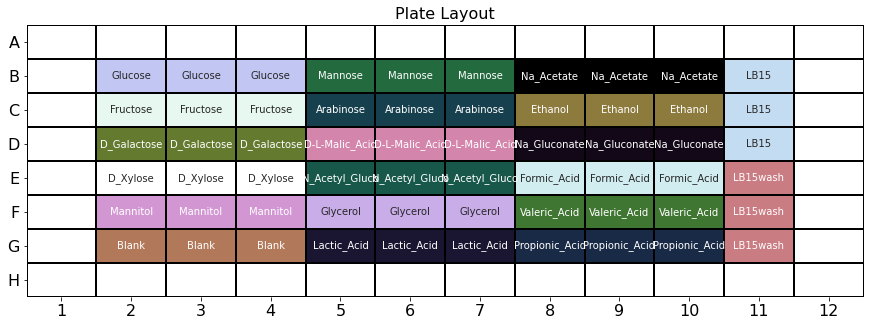

In [15]:
plate.show()

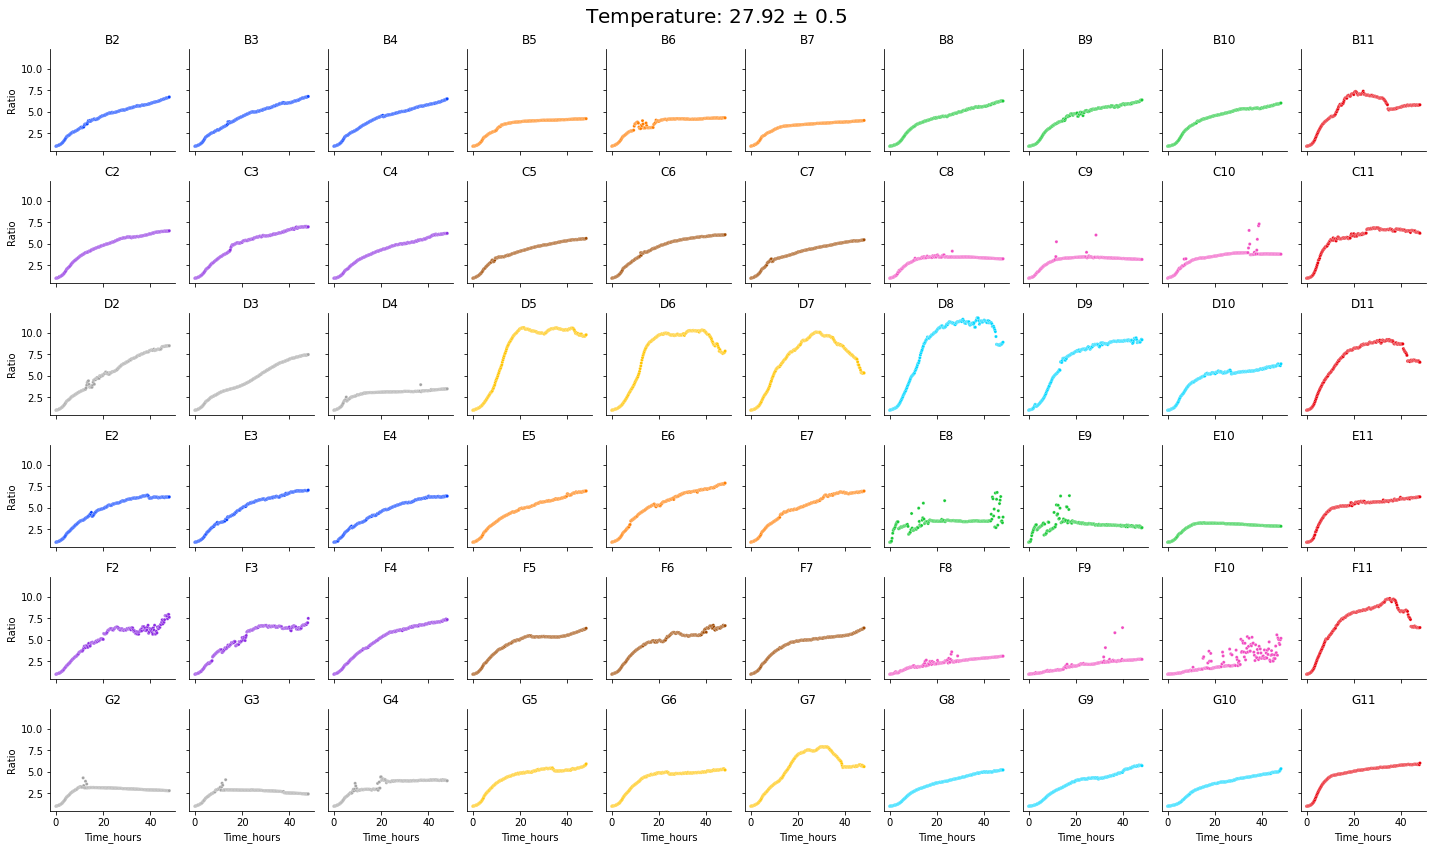

In [16]:
plate.show_all_curves()

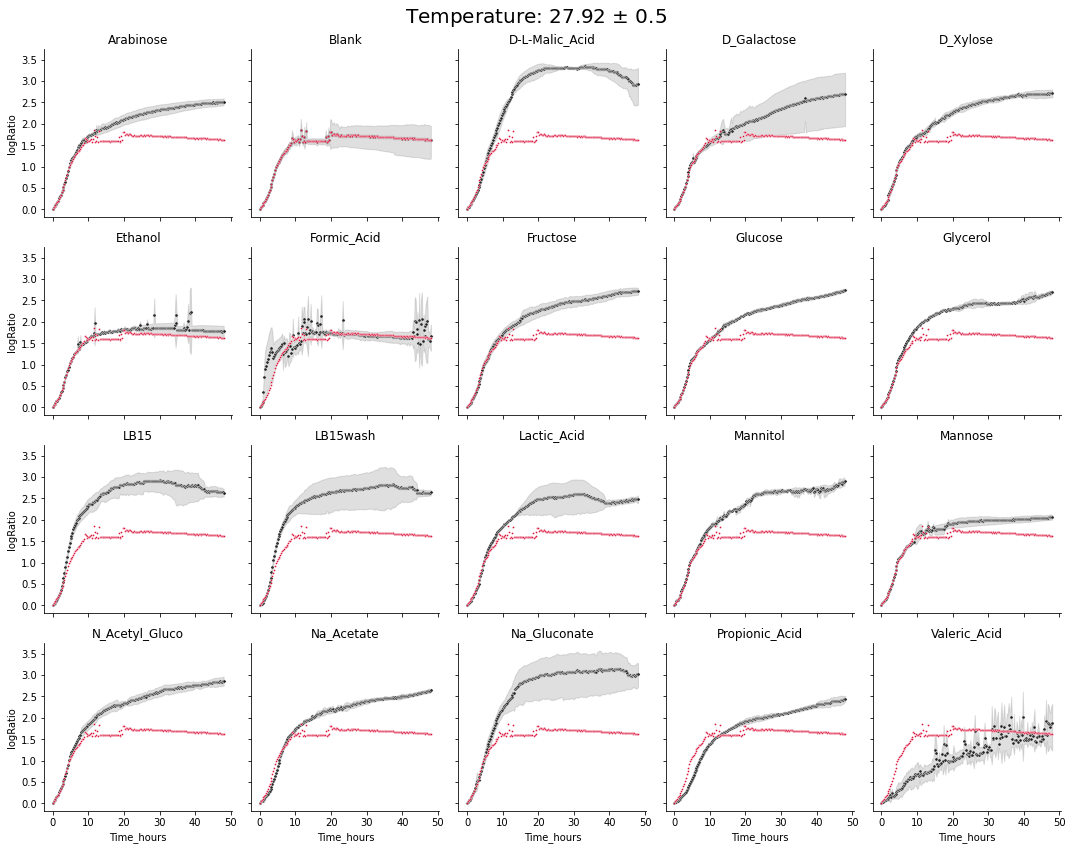

In [17]:
plate.show_combined_curves()

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time_hours', ylabel='logRatio'>,
 <models.Logistic2kZero at 0x7fa53ae93f40>)

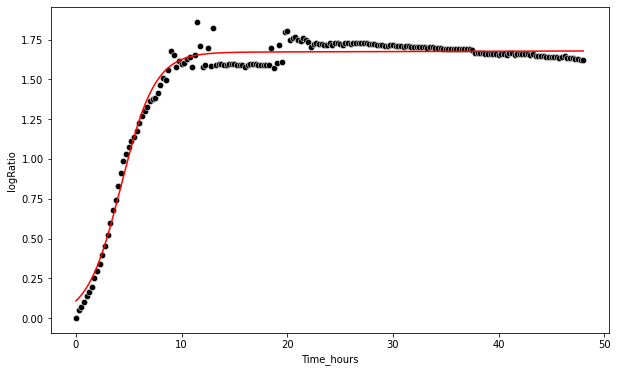

In [18]:
plate.show_fitted_curve(group='Blank')

(<seaborn.axisgrid.FacetGrid at 0x7fa559d2a040>,
 {'Na_Acetate': <models.Logistic2kZero at 0x7fa559d07370>,
  'Na_Gluconate': <models.Logistic2kZero at 0x7fa53c7d3a60>,
  'Lactic_Acid': <models.Logistic2kZero at 0x7fa53c770550>,
  'Propionic_Acid': <models.Logistic2kZero at 0x7fa53d3fd5e0>,
  'Arabinose': <models.Logistic2kZero at 0x7fa53d401ca0>,
  'N_Acetyl_Gluco': <models.Logistic2kZero at 0x7fa53d4074f0>,
  'Mannose': <models.Logistic2kZero at 0x7fa53d408eb0>,
  'Valeric_Acid': <models.Logistic2kZero at 0x7fa53d40ccd0>,
  'D_Galactose': <models.Logistic2kZero at 0x7fa53d410fa0>,
  'Ethanol': <models.Logistic2kZero at 0x7fa53d4125b0>,
  'Blank': <models.Logistic2kZero at 0x7fa53d412b50>,
  'LB15wash': <models.Logistic2kZero at 0x7fa53d412730>,
  'D-L-Malic_Acid': <models.Logistic2kZero at 0x7fa53d412c10>,
  'Mannitol': <models.Logistic2kZero at 0x7fa53d412f40>,
  'Glycerol': <models.Logistic2kZero at 0x7fa53d412760>,
  'Glucose': <models.Logistic2kZero at 0x7fa53d412f10>,
  'LB15': 

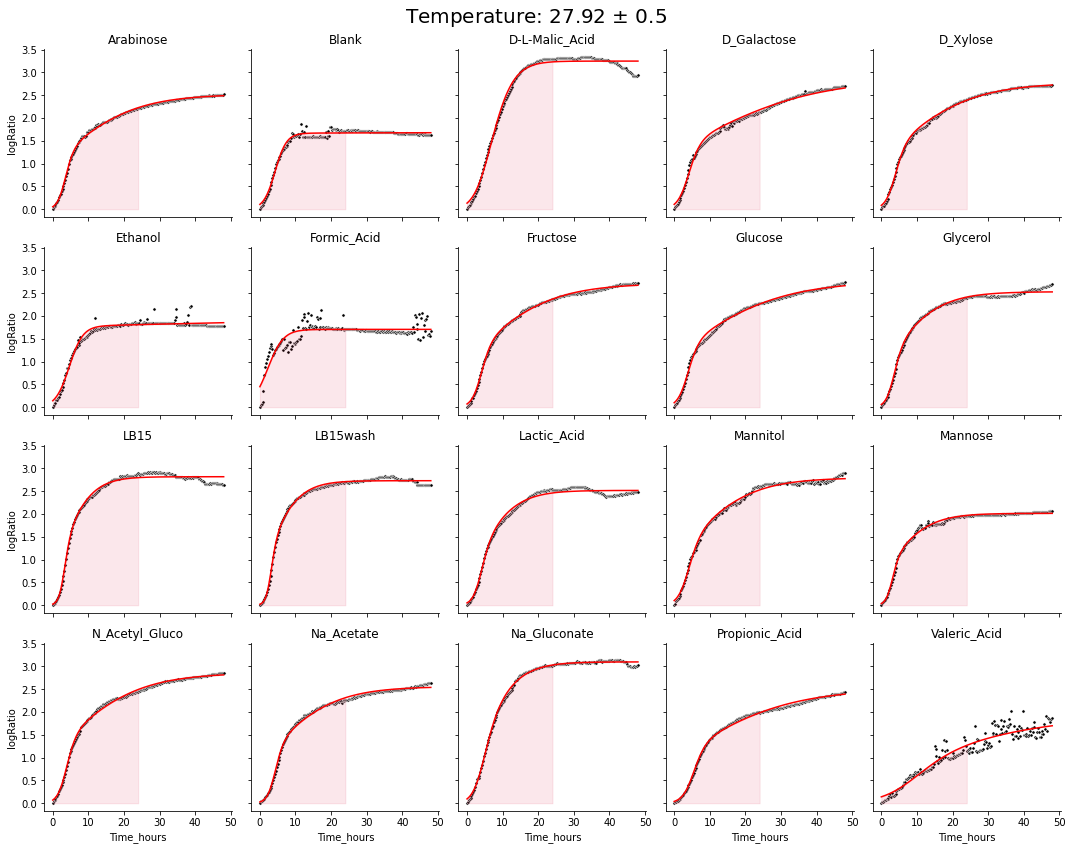

In [19]:
# You can specify the start and stop for shaded area region
plate.show_fitted_curves(modelname='logistic2kzero', a=0, b=24)

(<Figure size 576x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Temperatures'}, xlabel='Time_hours', ylabel='MeanTemp'>,
 (0        0.00
  1        0.25
  2        0.50
  3        0.75
  4        1.00
          ...  
  3855    47.00
  3856    47.25
  3857    47.50
  3858    47.75
  3859    48.00
  Name: Time_hours, Length: 3860, dtype: float64,
  0       25.0
  1       25.0
  2       25.1
  3       25.3
  4       25.5
          ... 
  3855    28.1
  3856    28.1
  3857    28.1
  3858    28.1
  3859    28.1
  Name: MeanTemp, Length: 3860, dtype: float64))

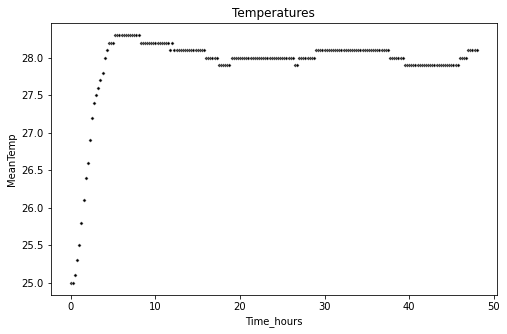

In [20]:
plate.show_temperatures()

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:ylabel='Estimated biomass'>,
 [('Na_Acetate', 96.6272727939461),
  ('Na_Gluconate', 124.10632284112549),
  ('Lactic_Acid', 102.00735567972474),
  ('Propionic_Acid', 84.22400342984191),
  ('Arabinose', 94.94021483819901),
  ('N_Acetyl_Gluco', 106.01597552462525),
  ('Mannose', 83.02730466853123),
  ('Valeric_Acid', 53.6163027154358),
  ('D_Galactose', 95.55714144437503),
  ('Ethanol', 78.48632958583163),
  ('Blank', 73.04085508460213),
  ('LB15wash', 114.5927104161484),
  ('D-L-Malic_Acid', 130.46510188533068),
  ('Mannitol', 106.15064101058789),
  ('Glycerol', 100.981670919065),
  ('Glucose', 97.87998997284733),
  ('LB15', 118.13019531054223),
  ('Formic_Acid', 77.02267702488797),
  ('Fructose', 100.58375965964849),
  ('D_Xylose', 101.85608130095528)])

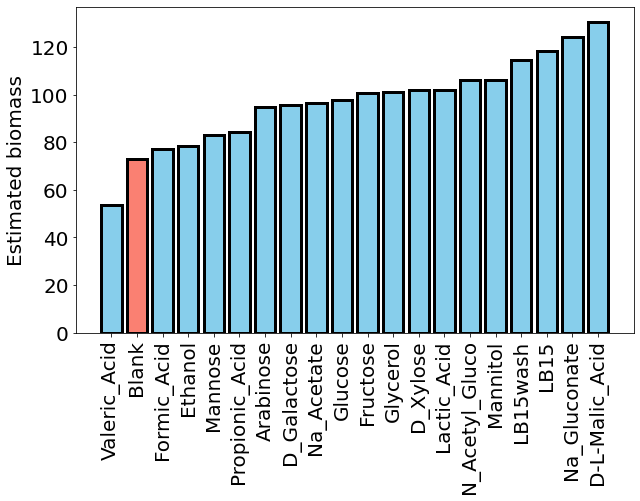

In [21]:
plate.show_areas()

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:ylabel='Max Growth Rate'>,
 [('Na_Acetate', 0.31409308970752436),
  ('Na_Gluconate', 0.3104321130266252),
  ('Lactic_Acid', 0.3087088642367201),
  ('Propionic_Acid', 0.2166468668196818),
  ('Arabinose', 0.3063718299931138),
  ('N_Acetyl_Gluco', 0.30823236674211735),
  ('Mannose', 0.3109185394718963),
  ('Valeric_Acid', 0.06049670437419038),
  ('D_Galactose', 0.24565897484236907),
  ('Ethanol', 0.2343168469089933),
  ('Blank', 0.26100666676747747),
  ('LB15wash', 0.5123182596269207),
  ('D-L-Malic_Acid', 0.2926238208876274),
  ('Mannitol', 0.2627120816663799),
  ('Glycerol', 0.31168620073268594),
  ('Glucose', 0.2579832201589365),
  ('LB15', 0.5019812904363232),
  ('Formic_Acid', 0.1948134983370034),
  ('Fructose', 0.27872810296432177),
  ('D_Xylose', 0.27245881491528173)])

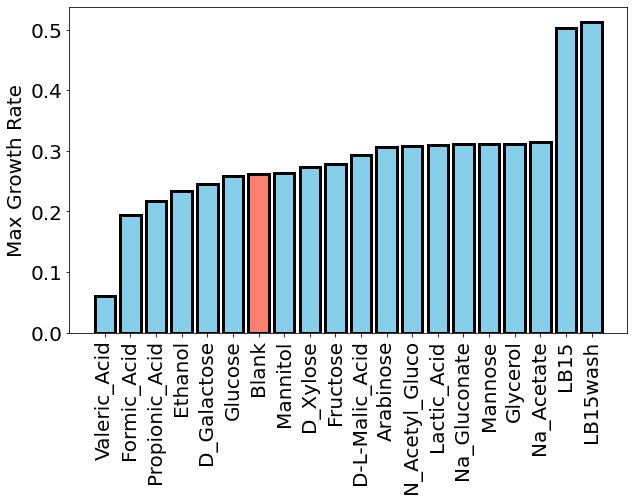

In [22]:
plate.show_rates()

(<Figure size 800x3000 with 60 Axes>,
 array([[<AxesSubplot:title={'center':'Function'}, ylabel='Na_Acetate'>,
         <AxesSubplot:title={'center':'1st Derivative'}>,
         <AxesSubplot:title={'center':'2nd Derivative'}>],
        [<AxesSubplot:ylabel='Na_Gluconate'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='Lactic_Acid'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='Propionic_Acid'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='Arabinose'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='N_Acetyl_Gluco'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='Mannose'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Valeric_Acid'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='D_Galactose'>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:ylabel='Ethanol'>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubp

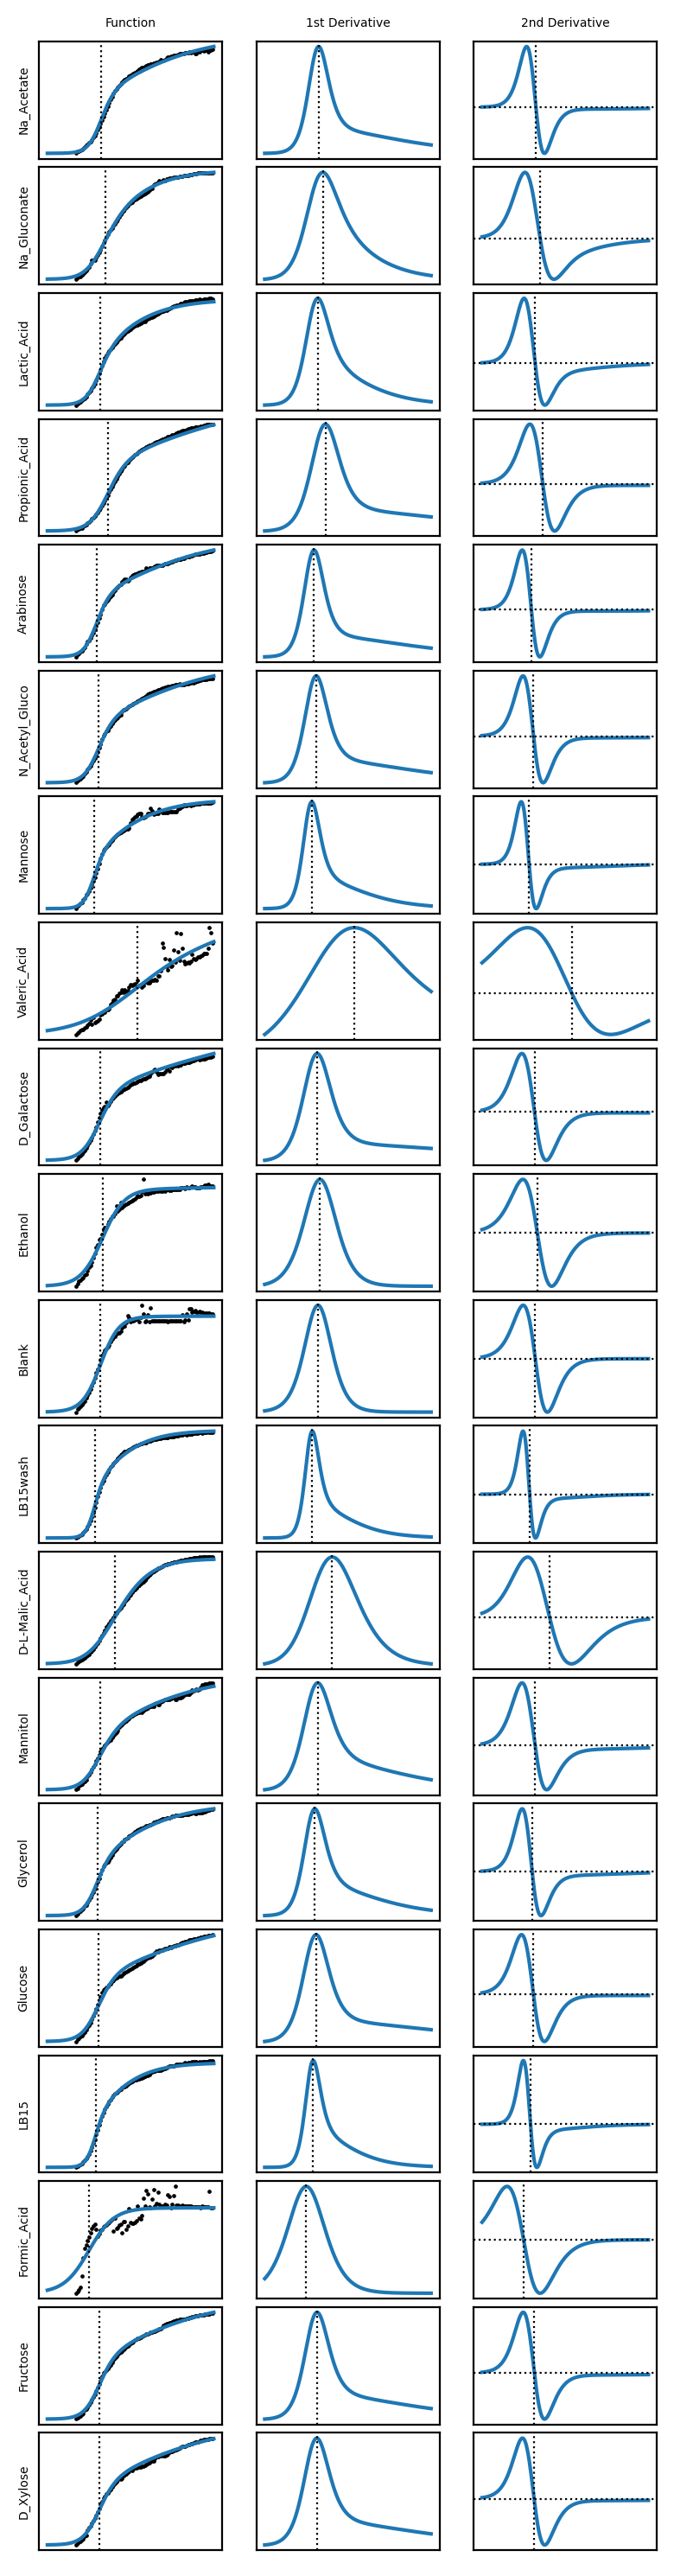

In [23]:
plate.show_model_derivatives()

# Fitting models
You can also fit models without plotting, both on a single group or on the whole plate, using the `fit_model()` method.
The `modelname` is the same as the corresponding model class (case insensitive):

* `LogisticZero`: logisticzero
* `Logistic2kZero`: logistic2kzero
* `Logistic2k`: logistic2k
* `GompertzZero`: gompertzzero
* `Gompertz`: gompertz
* `RichardsZero`: richardszero
* `Richards`: richards

This method returns a `models` object, as defined in the corresponding model class located in `models.py`.
With this object you can extract useful information from the fitted model.

**Beware**: Currently, all model fitting can only be done on the log-transformed data.

In [24]:
model = plate.fit_model(group='Glycerol', modelname='logistic2kzero')

### Symbolic representations

In [25]:
model.symbolic_func()

U/((1 + exp(-k1*(x - x0)))*(1 + exp(-k2*(x - x0))))

In [26]:
model.symbolic_deriv1()

U*k1*exp(-k1*(x - x0))/((1 + exp(-k1*(x - x0)))**2*(1 + exp(-k2*(x - x0)))) + U*k2*exp(-k2*(x - x0))/((1 + exp(-k1*(x - x0)))*(1 + exp(-k2*(x - x0)))**2)

In [27]:
model.symbolic_deriv2()

-U*k1**2*exp(-k1*(x - x0))/((1 + exp(-k1*(x - x0)))**2*(1 + exp(-k2*(x - x0)))) + 2*U*k1**2*exp(-2*k1*(x - x0))/((1 + exp(-k1*(x - x0)))**3*(1 + exp(-k2*(x - x0)))) + 2*U*k1*k2*exp(-k1*(x - x0))*exp(-k2*(x - x0))/((1 + exp(-k1*(x - x0)))**2*(1 + exp(-k2*(x - x0)))**2) - U*k2**2*exp(-k2*(x - x0))/((1 + exp(-k1*(x - x0)))*(1 + exp(-k2*(x - x0)))**2) + 2*U*k2**2*exp(-2*k2*(x - x0))/((1 + exp(-k1*(x - x0)))*(1 + exp(-k2*(x - x0)))**3)

### Data that the model is based on

In [28]:
model.x.head()

1737    0.00
1738    0.25
1739    0.50
1740    0.75
1741    1.00
Name: Time_hours, dtype: float64

In [29]:
model.y.head()

1737    0.000000
1738    0.040285
1739    0.079475
1740    0.102385
1741    0.132430
Name: logRatio, dtype: float64

### Maximum growth rate

In [30]:
model.max_growth_rate()

0.31168620073268594

### Area under the curve
Note that the implementation is not simply the integral of the function from $a$ to $b$.
The area is computed as (with $f(x)$ being the model function)

$$
A = (b - a) \min(f(a)) - \int_a^b f(x) dx
$$

This is in order to get a more intuitive estimate of the area, and in this way the area corresponds to the shaded area shown in the fitted curves above.

In [31]:
model.area_under_curve()

100.981670919065

### Optimized model parameters

In [32]:
model.vars

{'U': 2.533886834991552,
 'k1': 0.14636966459439596,
 'k2': 0.8120336393990021,
 'x0': 3.3043733367859844}

### Fitting on a full plate
Not specifying a group means a model will be fitted to all groups, and a dictionary of `group: model` is returned.
You can iterate over the dictionary to, for example, get out the areas for plotting.

### Looking at the derivatives

(<Figure size 1350x450 with 3 Axes>,
 (<AxesSubplot:title={'center':'Function'}>,
  <AxesSubplot:title={'center':'First Derivative'}>,
  <AxesSubplot:title={'center':'Second Derivative'}>))

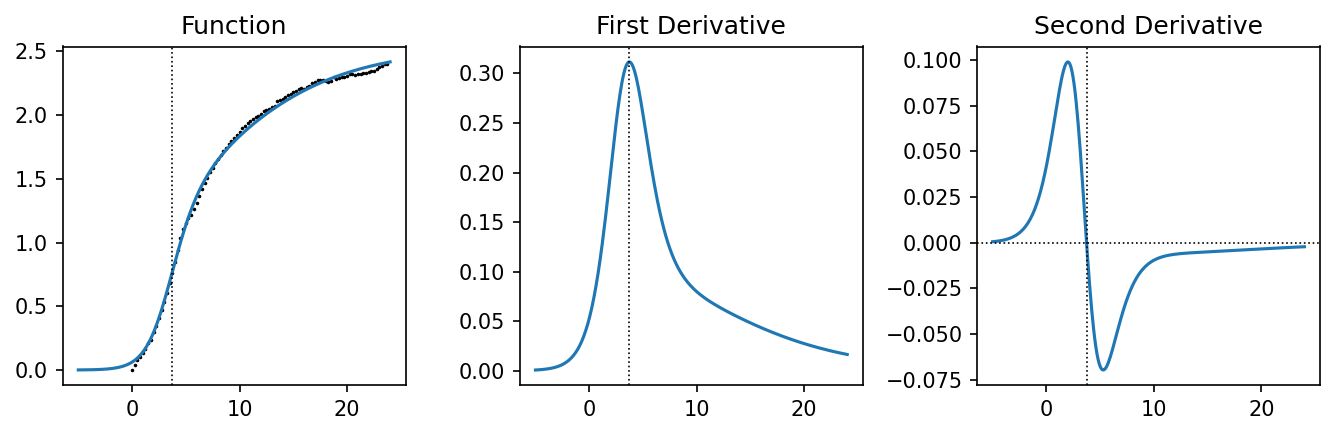

In [33]:
plate.show_model_derivatives(job='Glycerol')

# Performing a batch analyis
Lastly, the `analyze()` method can be used to go through all the plots and analyses in one go, and just print the results.
Perhaps this can be a quick way of summarizing the plate data.

`savefiles=True` will save all figures as PNGs and all displayed dataframes as CSVs.

In [34]:
help(plate.analyze)

Help on method analyze in module plate:

analyze(modelname='logistic2kzero', savefiles=False, outputdir=None) method of plate.Plate instance
    Perform curve fitting on all groups, and display all plots.



Files will be stored in MyTestAnalysis
Fitting models
Computing areas and rates
Generating figures


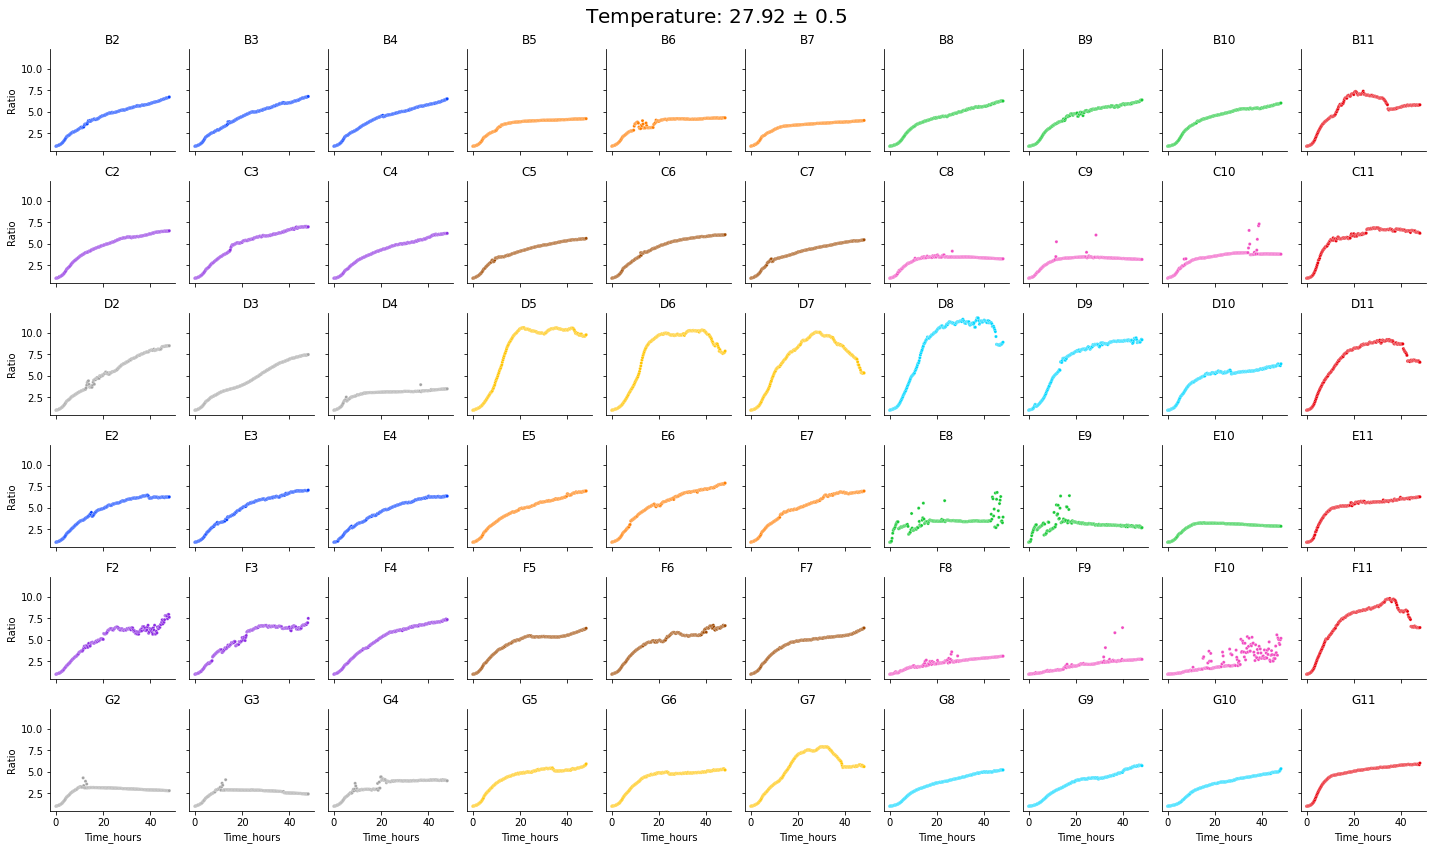

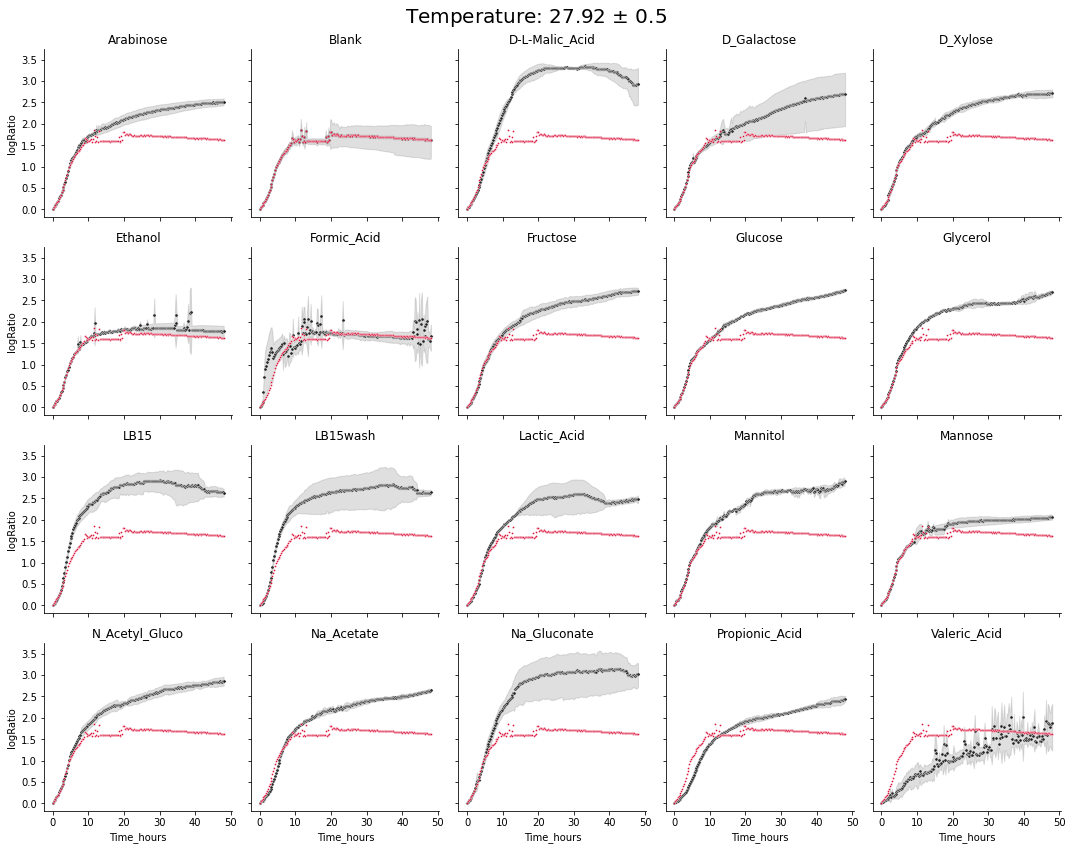

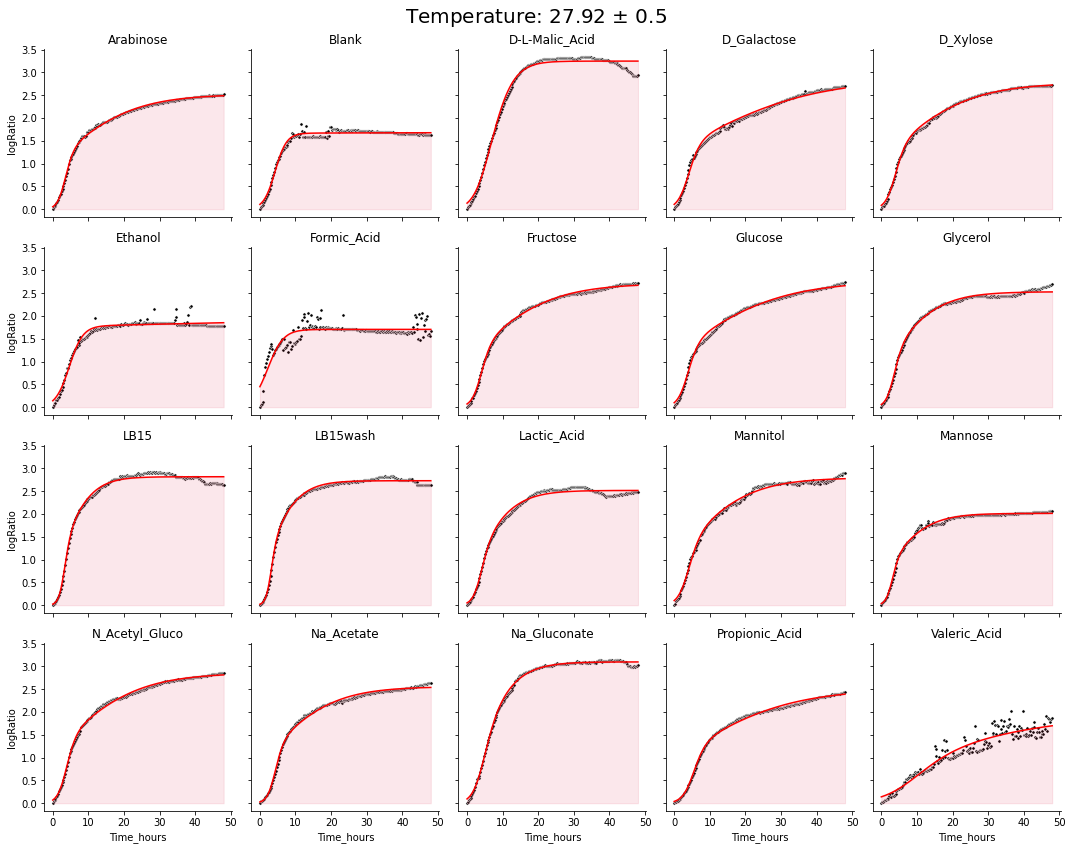

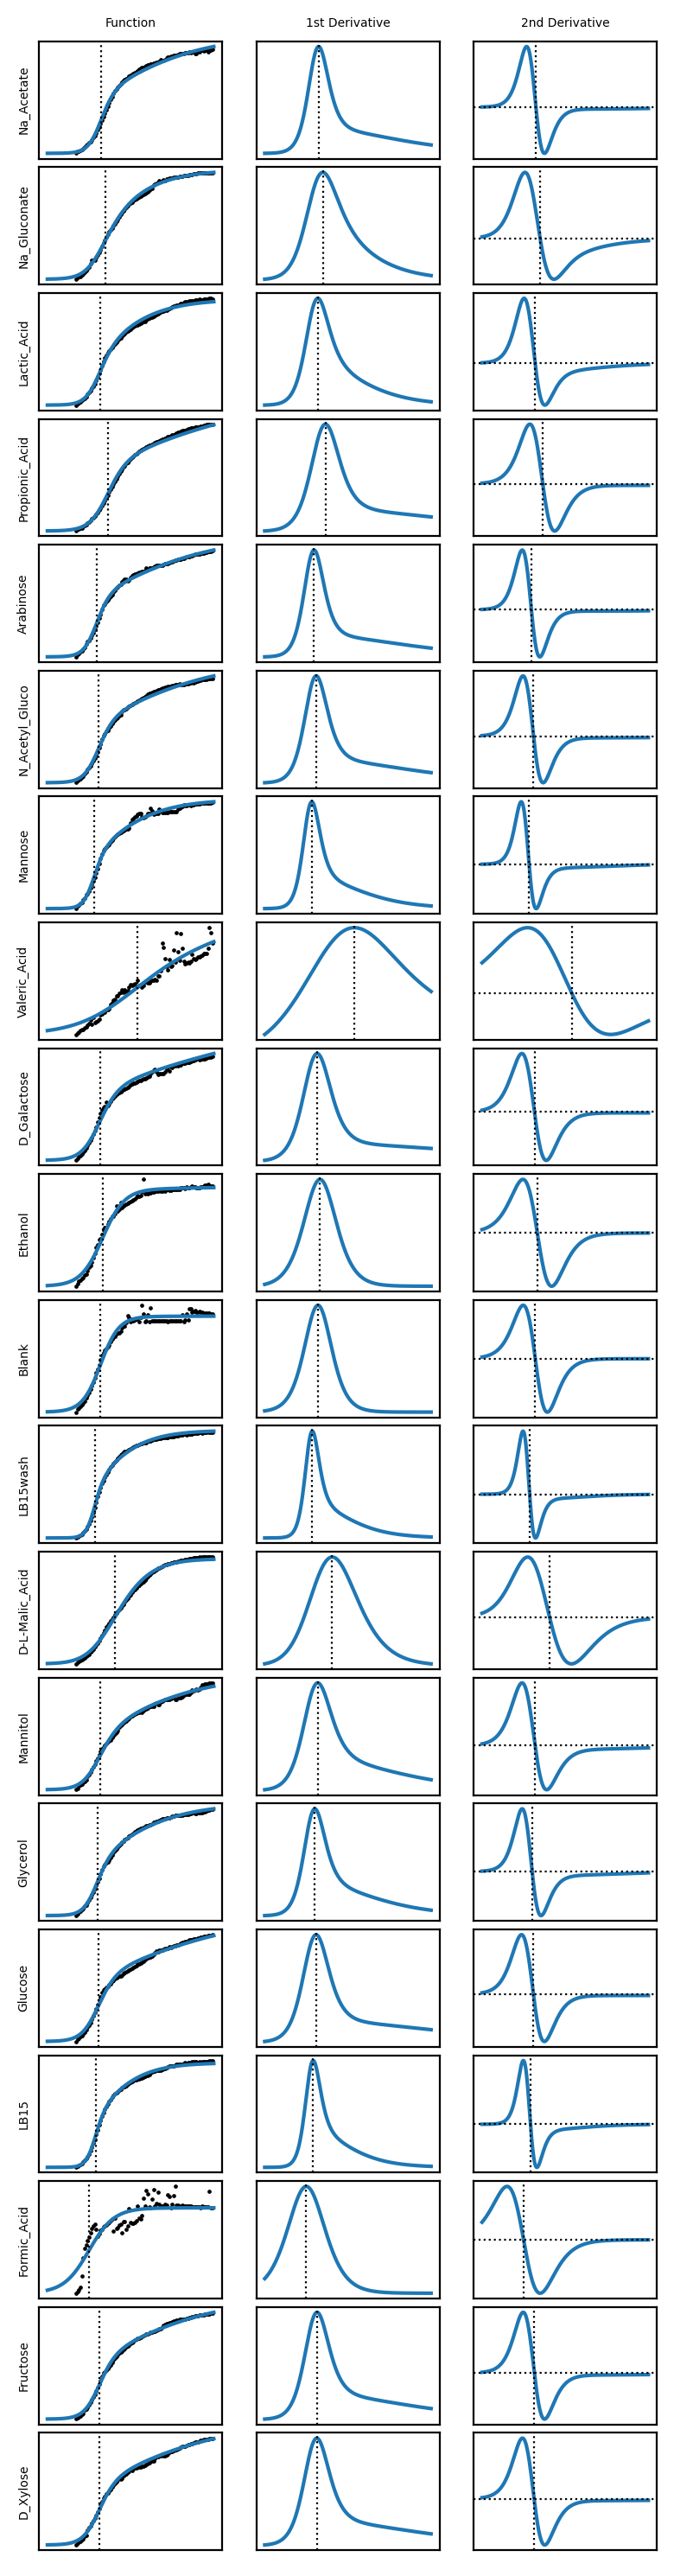

In [35]:
plate.analyze(savefiles=True, outputdir='MyTestAnalysis')

# Combining multiple `Plates`

In [36]:
template = 'Templates/Template_pseudomonas.csv'
raw = 'SampleData/Artificial2.csv'
plate2 = Plate(template=template, data=raw, blank_name='Blank', ID='SampleData2')

/Users/abr121/Documents/dev/Mikkel/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(<seaborn.axisgrid.FacetGrid at 0x7fa5457641c0>,
 <plate.Plate at 0x7fa5435535b0>)

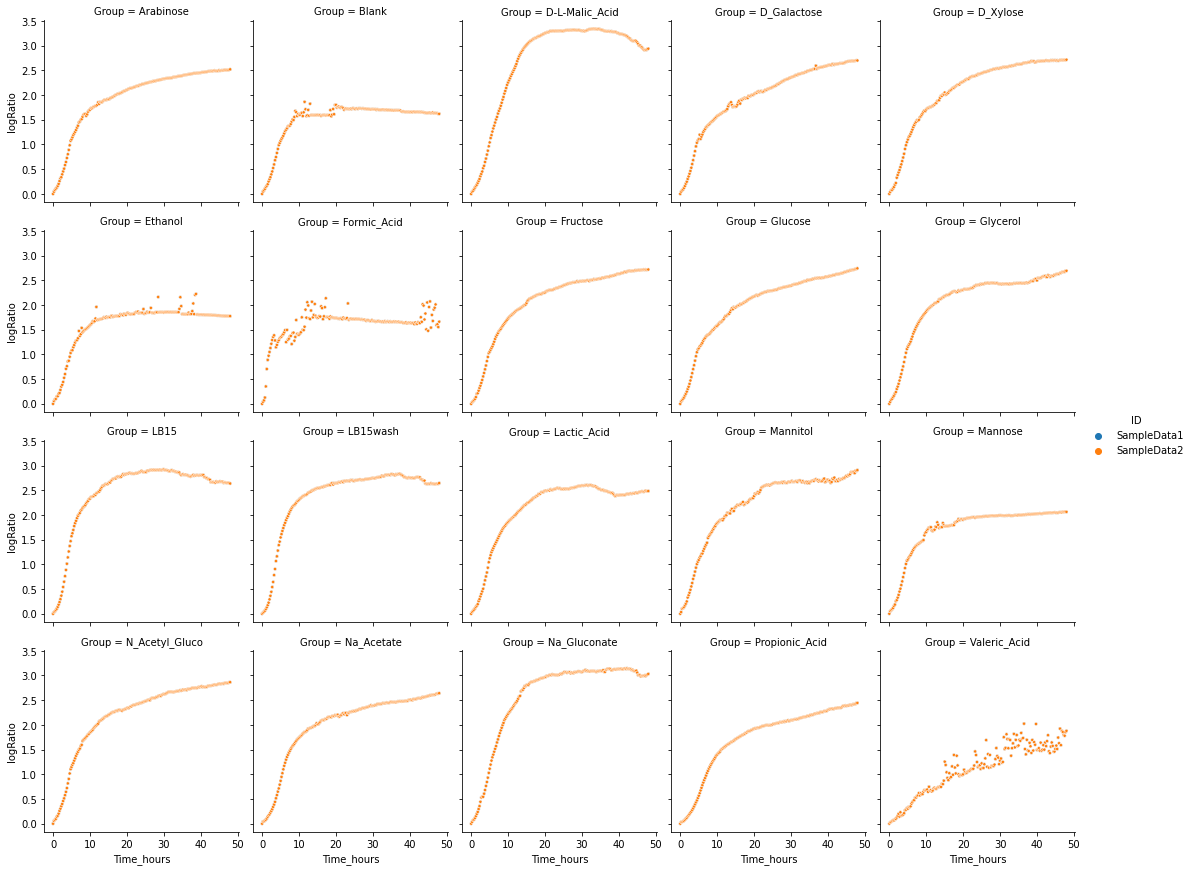

In [37]:
# not sure why the two datasets are overlapping...
plate.show_comparison_to(plate2)